# Magnetic pressure

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})

In [4]:
data_file_path = '../../data_out/fourth_batch_all_prop.txt'

In [5]:
data = np.loadtxt(data_file_path, delimiter=',')

In [6]:
key_nums = data[:, 0]
ras = data[:, 1]
decs = data[:, 2]
ls = data[:, 3]
bs = data[:, 4]
sizes = data[:, 5]
roundnesses = data[:, 6]
starting_velocities = data[:, 7]
velocity_spans = data[:, 8]
average_velocities = data[:, 9]
moment_0_means = data[:, 10]
moment_0_medians = data[:, 11]
moment_0_peaks = data[:, 12]
moment_0_means_raw = data[:, 13]
moment_0_medians_raw = data[:, 14]
moment_0_peaks_raw = data[:, 15]
moment_1_means = data[:, 16]
moment_1_medians = data[:, 17]
moment_2_means = data[:, 18]
moment_2_medians = data[:, 19]
moment_2_peaks = data[:, 20]
column_density_means = data[:, 21]
column_density_medians = data[:, 22]
column_density_peaks = data[:, 23]
column_density_means_raw = data[:, 24]
column_density_medians_raw = data[:, 25]
column_density_peaks_raw = data[:, 26]
width_fits = data[:, 27]
width_errs = data[:, 28]
width_chisq = data[:, 29]
width_fits_raw = data[:, 30]
width_errs_raw = data[:, 31]
width_chisq_raw = data[:, 32]

## From ferriere

### $F_\varepsilon (R, Z) = 0.46 \exp (- \frac{R - R_\bigodot}{2.8 kpc})(sech \frac{Z}{255 pc})^{n(R)} + 0.54 \exp(- \frac{R - R_\bigodot}{3.3kpc})(sech \frac{Z}{255 pc})^{b(R)})$

### $P_\mathrm{M} (R, Z) = (10.0 \times 10^{-13} \mathrm{dyn\ cm^{-2}})[F_\varepsilon(R,Z)]^{0.53}$

### $R_\bigodot = 8.5 \mathrm{kpc}$, and at solar circle, $n(R_\bigodot) = 4.6$ and $b(R_\bigodot) = 0.187$

In [7]:
def get_pressure_m(zs, rs=None):
    """ get the magnetic pressure from list of z heights
    assume solar circle if rs not given
    """
    r_solar = 8500  # pc
    if rs is None:
        rs = np.ones_like(zs) * r_solar
    def f_eps(rs, zs):
        f_e = .46 * np.exp(- (rs - r_solar) / 2800) * (1 / np.cosh(zs / 255)) ** 4.6 \
            + .54 * np.exp(- (rs - r_solar) / 3300) * (1 / np.cosh(zs / 255)) ** 0.187
        return f_e
    return 10e-13 * f_eps(rs, zs) ** 0.53

In [8]:
zs_test = np.arange(0, 3000., 10)
p_m_test = get_pressure_m(zs_test)

/Users/larryli/anaconda/envs/py27research/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


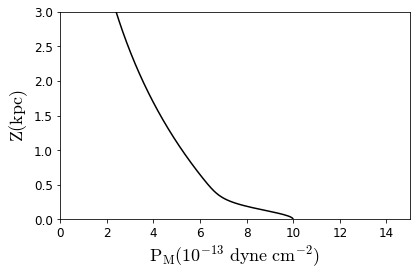

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(p_m_test * 1e13, zs_test / 1000, color='black')
ax.set_xlim(0, 15)
ax.set_ylim(0, 3)
ax.set_xlabel(r'$\mathrm{P_M} (10^{-13}\ \mathrm{dyne\ cm^{-2}})$', fontsize=18)
ax.set_ylabel(r'$\mathrm{Z} (\mathrm{kpc})$', fontsize=18)
fig.tight_layout()
fig.show()

In [11]:
v_cut = 10
b_cut = 30

In [12]:
local_idx = (np.abs(moment_1_means) < v_cut) & ((np.abs(bs) > b_cut) | (np.abs(bs) < b_cut) & ((ls < 90) | (ls > 270)))
# (v < 10) AND (b > 30 OR (b < 30 AND not galactic 180))

In [13]:
def get_z(ds, bs):
    soloar_offset = 0
    zs = np.sin(bs * (np.pi / 180)) * ds - soloar_offset
    return zs

In [14]:
ds = np.ones_like(bs) * 100.
zs = get_z(ds, bs)
p_m = get_pressure_m(zs)

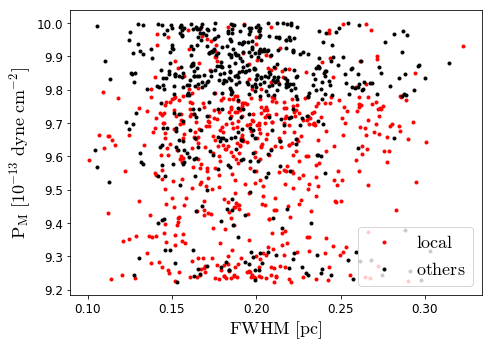

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.plot(width_fits_raw[local_idx], p_m[local_idx] * 1e13, '.', color='red', label=r'$\mathrm{local}$')
ax.plot(width_fits_raw[~local_idx], p_m[~local_idx] * 1e13, '.', color='black', label=r'$\mathrm{others}$')
ax.legend(fontsize=18)
ax.set_xlabel(r'$\mathrm{FWHM}\ [\mathrm{pc}]$', fontsize=18)
ax.set_ylabel(r'$\mathrm{P_M}\ [10^{-13}\ \mathrm{dyne\ cm^{-2}}]$', fontsize=18)
#ax.set_xlim(0.075, 0.35)
fig.tight_layout()
fig.show()

In [44]:
fig.savefig('../../vis/all_sky_maps_fourth_batch/fwhm_vs_m_pressure_fixed_distance.pdf')

In [18]:
stilism_dist_data = np.loadtxt('../../dist_data/fourth_batch_all_prop_corr_lbdistances.txt', delimiter=' ')
stilism_dist = stilism_dist_data[:,2]
stilism_dist_err = stilism_dist_data[:,4]
stilism_lower_lim_flag = stilism_dist_data[:,6]

In [19]:
flatcurve_dist = np.loadtxt('../../dist_data/fourth_batch_flatcurve_dist.txt', delimiter=',')

In [20]:
dist = np.zeros_like(stilism_dist)
dist[local_idx] = stilism_dist[local_idx]
dist[~local_idx] = flatcurve_dist[~local_idx]

In [23]:
dist[dist < 75] = 100
lower_bound_flag = (dist > 9999)

In [25]:
width_fits_raw_dcorr = width_fits_raw * (dist / 100)

In [21]:
zs = get_z(dist, bs)
zs_fixed = get_z(np.ones_like(bs) * 100, bs)
p_m = get_pressure_m(zs_fixed)

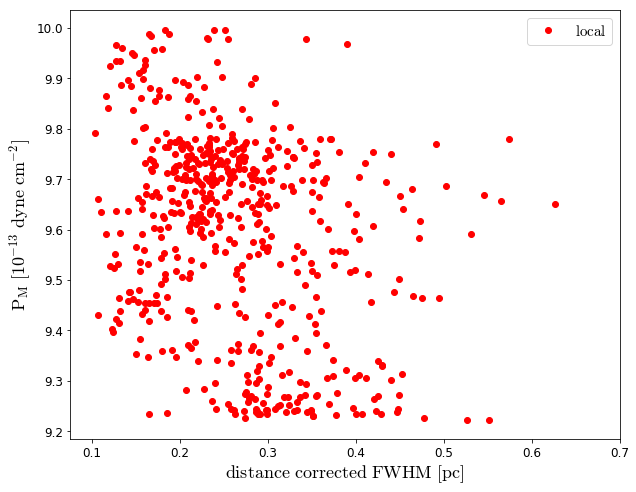

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax.plot(width_fits_raw_dcorr[local_idx], p_m[local_idx] * 1e13, 'o', color='red',
        label=r'$\mathrm{local}$')
#ax.plot(width_fits_raw_dcorr[~local_idx], p_m[~local_idx] * 1e13, '.', color='blue', alpha=.9,
#        label=r'$\mathrm{others}$')
ax.legend(fontsize=15)
ax.set_xlabel(r'$\mathrm{distance\ corrected\ FWHM}\ [\mathrm{pc}]$', fontsize=18)
ax.set_ylabel(r'$\mathrm{P_M}\ [10^{-13}\ \mathrm{dyne\ cm^{-2}}]$', fontsize=18)
ax.set_xlim(0.075, .7)
fig.tight_layout()
fig.show()

In [46]:
fig.savefig('../../vis/all_sky_maps_fourth_batch/dcorr_fwhm_vs_m_pressure.pdf')

# fixed distance, varying z height

(array([ 138.,  166.,   88.,   41.,   18.,   29.,   34.,   11.,    6.,    2.]),
 array([  70.,  109.,  148.,  187.,  226.,  265.,  304.,  343.,  382.,
         421.,  460.]),
 <a list of 10 Patch objects>)

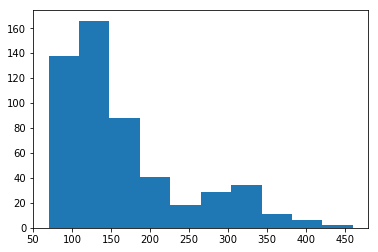

In [120]:
plt.hist(dist)


In [121]:
dist_100_idx = ((dist >= 90) & (dist < 110))
dist_120_idx = ((dist >= 110) & (dist < 130))
dist_140_idx = ((dist >= 130) & (dist < 150))
dist_160_idx = ((dist >= 150) & (dist < 170))

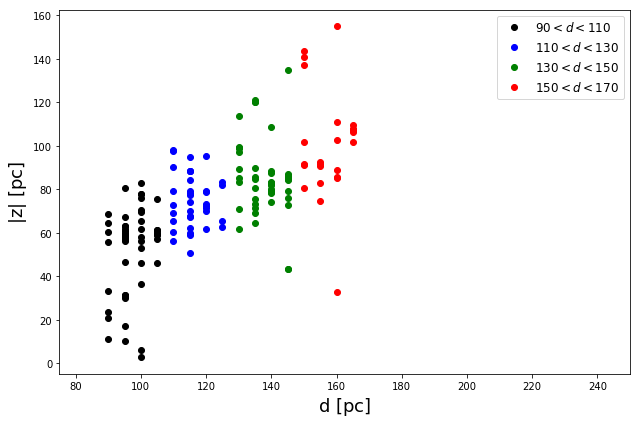

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(dist[np.logical_and(idx, dist_100_idx)], np.abs(zs[np.logical_and(idx, dist_100_idx)]), 'o',
        color='black', label=r'$90 < d<110$')
ax.plot(dist[np.logical_and(idx, dist_120_idx)], np.abs(zs[np.logical_and(idx, dist_120_idx)]), 'o',
        color='blue', label=r'$110< d<130$')
ax.plot(dist[np.logical_and(idx, dist_140_idx)], np.abs(zs[np.logical_and(idx, dist_140_idx)]), 'o',
        color='green', label=r'$130< d<150$')
ax.plot(dist[np.logical_and(idx, dist_160_idx)], np.abs(zs[np.logical_and(idx, dist_160_idx)]), 'o',
        color='red', label=r'$150< d<170$')
ax.legend(fontsize=12)
ax.set_xlim(75, 250)
ax.set_xlabel(r'$\mathrm{d\ [pc]}$', fontsize=18)
ax.set_ylabel(r'$\mathrm{|z|\ [pc]}$', fontsize=18)
fig.tight_layout()
fig.show()

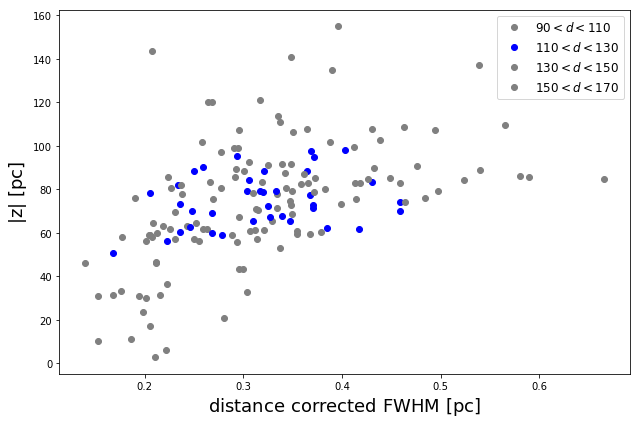

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(corr_fwhm[np.logical_and(idx, dist_100_idx)], np.abs(zs[np.logical_and(idx, dist_100_idx)]), 'o',
        color='grey', label=r'$90 < d<110$')
ax.plot(corr_fwhm[np.logical_and(idx, dist_120_idx)], np.abs(zs[np.logical_and(idx, dist_120_idx)]), 'o',
        color='blue', label=r'$110< d<130$')
ax.plot(corr_fwhm[np.logical_and(idx, dist_140_idx)], np.abs(zs[np.logical_and(idx, dist_140_idx)]), 'o',
        color='grey', label=r'$130< d<150$')
ax.plot(corr_fwhm[np.logical_and(idx, dist_160_idx)], np.abs(zs[np.logical_and(idx, dist_160_idx)]), 'o',
        color='grey', label=r'$150< d<170$')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\mathrm{distance\ corrected\ FWHM}\ [\mathrm{pc}]$', fontsize=18)
ax.set_ylabel(r'$\mathrm{|z|\ [pc]}$', fontsize=18)
fig.tight_layout()
fig.show()

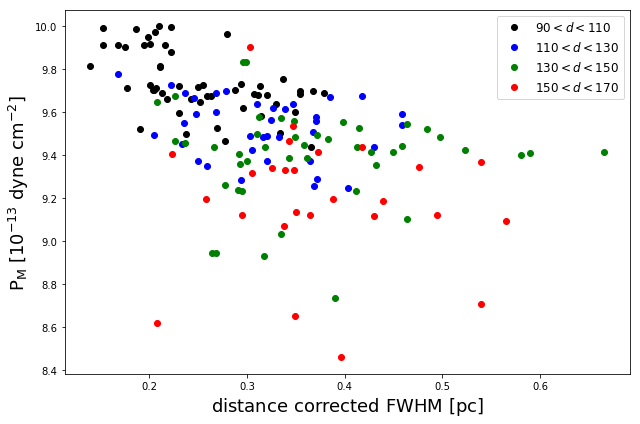

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(corr_fwhm[np.logical_and(idx, dist_100_idx)], np.abs(p_m[np.logical_and(idx, dist_100_idx)]* 1e13), 'o',
        color='black', label=r'$90 < d<110$')
ax.plot(corr_fwhm[np.logical_and(idx, dist_120_idx)], np.abs(p_m[np.logical_and(idx, dist_120_idx)]* 1e13), 'o',
        color='blue', label=r'$110< d<130$')
ax.plot(corr_fwhm[np.logical_and(idx, dist_140_idx)], np.abs(p_m[np.logical_and(idx, dist_140_idx)]* 1e13), 'o',
        color='green', label=r'$130< d<150$')
ax.plot(corr_fwhm[np.logical_and(idx, dist_160_idx)], np.abs(p_m[np.logical_and(idx, dist_160_idx)]* 1e13), 'o',
        color='red', label=r'$150< d<170$')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\mathrm{distance\ corrected\ FWHM}\ [\mathrm{pc}]$', fontsize=18)
ax.set_ylabel(r'$\mathrm{P_M}\ [10^{-13}\ \mathrm{dyne\ cm^{-2}}]$', fontsize=18)
fig.tight_layout()
fig.show()

# Fixed |b|

In [125]:
b_50_idx = ((np.abs(bs) > 40) & (np.abs(bs) < 60))

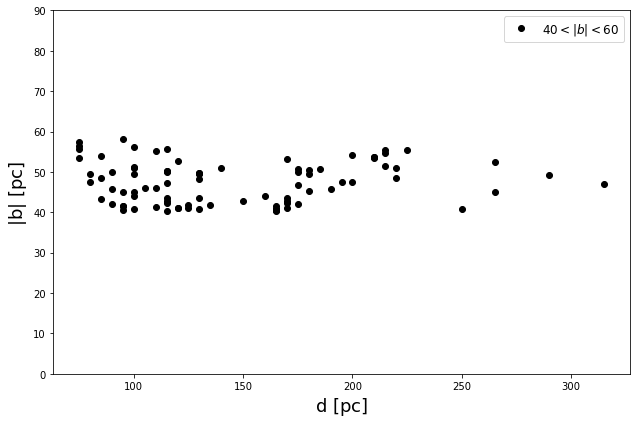

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(dist[np.logical_and(idx, b_50_idx)], np.abs(bs[np.logical_and(idx, b_50_idx)]), 'o',
        color='black', label=r'$40 < |b| < 60$')
ax.legend(fontsize=12)
ax.set_ylim(0,90)
ax.set_xlabel(r'$\mathrm{d\ [pc]}$', fontsize=18)
ax.set_ylabel(r'$\mathrm{|b|\ [pc]}$', fontsize=18)
fig.tight_layout()
fig.show()

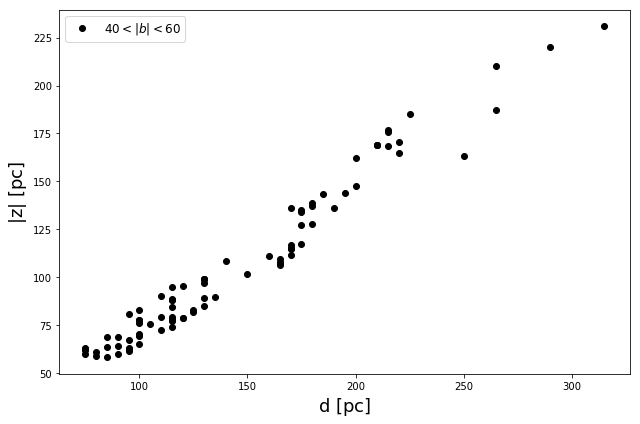

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(dist[np.logical_and(idx, b_50_idx)], np.abs(zs[np.logical_and(idx, b_50_idx)]), 'o',
        color='black', label=r'$40 < |b| < 60$')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\mathrm{d\ [pc]}$', fontsize=18)
ax.set_ylabel(r'$\mathrm{|z|\ [pc]}$', fontsize=18)
fig.tight_layout()
fig.show()

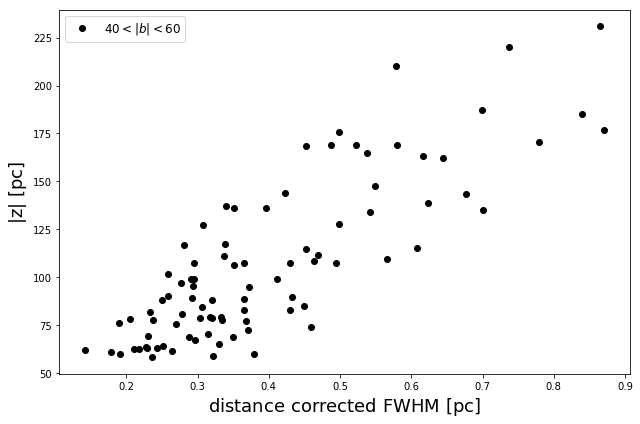

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(corr_fwhm[np.logical_and(idx, b_50_idx)], np.abs(zs[np.logical_and(idx, b_50_idx)]), 'o',
        color='black', label=r'$40 < |b| < 60$')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\mathrm{distance\ corrected\ FWHM}\ [\mathrm{pc}]$', fontsize=18)
ax.set_ylabel(r'$\mathrm{|z|\ [pc]}$', fontsize=18)
fig.tight_layout()
fig.show()

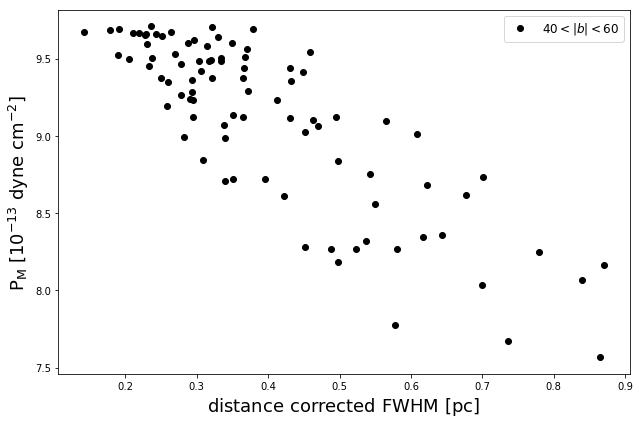

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
ax.plot(corr_fwhm[np.logical_and(idx, b_50_idx)], np.abs(p_m[np.logical_and(idx, b_50_idx)]) * 1e13, 'o',
        color='black', label=r'$40 < |b| < 60$')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\mathrm{distance\ corrected\ FWHM}\ [\mathrm{pc}]$', fontsize=18)
ax.set_ylabel(r'$\mathrm{P_M}\ [10^{-13}\ \mathrm{dyne\ cm^{-2}}]$', fontsize=18)
fig.tight_layout()
fig.show()